In [1]:
import pandas as pd
import numpy as np
from numpy import sort
import copy
import math
import cmath
import datetime

from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectFromModel
import joblib


from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt

# Function

In [2]:

def calculate_LR_2(df):
    """
    df:training set
    """
    # log ((2+c)/(1+c)) + log ((2+c)/ (1+c)), {c==1}


    p = {}
    n = {}
    for index,row in df.iterrows():
        if(pd.isna(row['ancestor'])):
            continue
        for i in row['ancestor'].split(','):
            if i not in p.keys():
                p[i]=1
                n[i]=1
            if(row['is_del']==1):
                p[i]+=1
            else:
                n[i]+=1
                
    l = copy.deepcopy(p)
    for i in l.keys():
        l[i]=math.log(p[i]/n[i]) 
    l
    

    def LR_add(x):
        sum=0
        if(pd.isna(x)):
            return sum
        for i in x.split(','):
            sum=sum+l[i]
        return sum
    df['LR'] = df['ancestor'].apply(lambda x:LR_add(x))
    df = df.drop(columns=['ancestor'])
    return df

In [3]:

def calculate_PA_2(df):
    """
    df:training set
    """
    # log ((2+c)/(1+c)) + log ((2+c)/ (1+c)), {c==1}


    p = {}
    n = {}
    for index,row in df.iterrows():
        if(pd.isna(row['site'])):
            continue
        for i in row['site'].split(','):
            if i!='':
                if i not in p.keys():
                    p[i]=1
                    n[i]=1
                if(row['is_del']==1):
                    p[i]+=1
                else:
                    n[i]+=1
                
    l = copy.deepcopy(p)
    for i in l.keys():
        l[i]=math.log(p[i]/n[i]) 
    l
    

    def PA_add(x):
        sum=0
        if(pd.isna(x)):
            return sum
        for i in x.split(','):
            if i!='':
                sum=sum+l[i]
        return sum
    df['PA'] = df['site'].apply(lambda x:PA_add(x))
    df = df.drop(columns=['site'])
    return df

In [4]:


def tolerance_metrics(y_true, y_pre):

    #     y_true, y_pre = y_test1, p_test1
    label = pd.DataFrame({'true': y_true, 'pre': y_pre})


    unique_state = label.true.unique()
    targets = {}
    state_map = {1: 'p', 0: 'n', '0': 'p', '0': 'n'}
    tp = fp = tn = fn = 0
    for i, (t, p) in label.iterrows():
        if t == 0 and p == 0:
            tn += 1
        if t == 0 and p == 1:
            fp += 1
        if t == 1 and p == 1:
            tp += 1
        if t == 1 and p == 0:
            fn += 1

    allp = tp + fn
    alln = fp + tn


    N = tp + tn + fp + fn
    # ppv
    ppv = tp / (tp + fp)
    # npv
    npv = tn / (tn + fn)
    # sensitivity -> TPR
    sen = tp / (tp + fn)
    # spciticity -> TNR
    spe = tn / (tn + fp)
    # acc
    acc = (tp + tn) / N
    # MCC
    mcc = (tp*tn-fp*fn) /(((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))**0.5)
    columns = ['tp', 'tn', 'fp', 'fn', 'ppv', 'npv', 'tpr', 'tnr', 'acc', 'mcc']
    res2 = pd.DataFrame(
        [
            [tp, tn, fp, fn, ppv, npv, sen, spe, acc, mcc]
        ], 
        columns=columns,
    )


    return res2

# WithGO

# All

# Feature_select

In [5]:
train_site = pd.read_csv('./Dataset/Train_Site.csv')
train_site

,gi_x,variation,UID,is_del,mut_residue,site
0,NP_542172.2,M1V,Q96L58,1,1,",Chain,Topological domain"
1,NP_542172.2,D156N,Q96L58,1,156,",Chain,Topological domain,Natural variant"
2,NP_542172.2,S159Y,Q96L58,1,159,",Chain,Topological domain"
3,NP_542172.2,R232C,Q96L58,1,232,",Chain,Topological domain,Natural variant"
4,NP_001164006.1,R528W,Q9NVI7,1,528,",Chain,Topological domain,Natural variant"
...,...,...,...,...,...,...
45568,P02857,Q27E,P02857,0,27,",Chain"
45569,P05037,V14G,P05037,0,14,",Chain"
45570,Q40983,H236L,Q40983,1,236,",Mutagenesis,Chain,Metal binding"
45571,Q40983,E239Q,Q40983,1,239,",Mutagenesis,Chain,Active site"


In [6]:
human = pd.read_csv('./Dataset/Human_train.csv')
animal = pd.read_csv('./Dataset/Animal_train.csv')
plant = pd.read_csv('./Dataset/Plant_train.csv')
train = pd.concat([human, animal, plant])
train['pos_1']=train['mut_residue'].apply(lambda x:1 if x==1 else 0)
train = pd.merge(train, train_site[['gi_x','variation','site']], how='left', left_on=['gi_x','variation'],right_on=['gi_x','variation'])
train = calculate_LR_2(train)
train = calculate_PA_2(train)
train

,gi_x,variation,UID,is_del,mut_residue,nutation,len,ANDN920101,ARGP820101,ARGP820102,...,NonPolarAA,PolarAA,ChargedAA,PosAA,NegAA,hits,score,pos_1,LR,PA
0,NP_542172.2,M1V,Q96L58,1,1,MV,329,0.57,-0.14,1.59,...,6,0,6,0,6,6,0.00,1,11.593731,-0.194768
1,NP_542172.2,D156N,Q96L58,1,156,DN,329,0.01,0.40,-0.18,...,13,1,9,6,3,6,0.08,0,11.593731,0.595925
2,NP_542172.2,S159Y,Q96L58,1,159,SY,329,-0.10,-1.83,0.58,...,14,1,8,6,2,6,0.08,0,11.593731,-0.194768
3,NP_542172.2,R232C,Q96L58,1,232,RC,329,-0.27,-0.47,-1.69,...,11,3,9,4,5,6,0.05,0,11.593731,0.595925
4,NP_001164006.1,R528W,Q9NVI7,1,528,RW,329,-0.32,-2.05,-0.57,...,12,1,10,7,3,39,0.01,0,14.290132,0.595925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45568,P02857,Q27E,P02857,0,27,QE,517,0.08,-0.47,0.61,...,10,7,6,4,2,30,0.71,0,-0.693147,-0.194768
45569,P05037,V14G,P05037,0,14,VG,491,-0.02,1.25,0.59,...,10,8,5,3,2,399,0.02,0,36.515731,-0.194768
45570,Q40983,H236L,Q40983,1,236,HL,1257,0.46,-0.92,-2.92,...,11,2,10,7,3,4,0.00,0,4.744020,7.350220
45571,Q40983,E239Q,Q40983,1,239,EQ,1257,-0.08,0.47,-0.61,...,10,2,11,6,5,4,0.00,0,4.744020,7.836079


# 1

In [ ]:
y_train = train.is_del.values
X_train = train.iloc[:,train.columns != "nutation"].iloc[:,4:]

model = lgb.LGBMClassifier()
rfe=RFE(estimator=model,n_features_to_select=1,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_1/lightgbm_feature_select_1.rfe")

In [ ]:
rfe = joblib.load('Feature_selected/lightgbm_feature_select_1.rfe')
print("LGBM-RFE特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfe.n_features_)
rank = list(rfe.ranking_)
columns = X_train.columns.tolist()
feature_selected = pd.DataFrame({'rank':rank,'feature':columns})
feature_selected

plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
plt.show()
feature_selected[feature_selected['rank']==1].iloc[:,1:]

# 10

In [8]:
y_train = train.is_del.values
X_train = train.iloc[:,train.columns != "nutation"].iloc[:,4:]

model = lgb.LGBMClassifier()
rfe=RFE(estimator=model,n_features_to_select=10,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_1/lightgbm_feature_select_10.rfe")

[ True  True False ... False  True  True]
[  1   1 285 ...  28   1   1]


['Feature_selected/lightgbm_feature_select_10.rfe']

LGBM-RFE特征选择结果——————————————————————————————————————————————————
有效特征个数 : 10


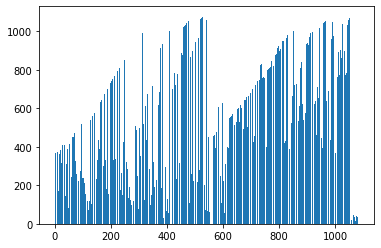

,feature
0,mut_residue
1,len
413,FUKS010101
559,DOSZ010103
1067,AA20D.P
1075,NonPolarAA
1080,hits
1081,score
1083,LR
1084,PA


In [12]:
rfe = joblib.load('Feature_selected/lightgbm_feature_select_10.rfe')
print("LGBM-RFE特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfe.n_features_)
rank = list(rfe.ranking_)
columns = X_train.columns.tolist()
feature_selected = pd.DataFrame({'rank':rank,'feature':columns})
feature_selected

plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
plt.show()
feature_selected[feature_selected['rank']==1].iloc[:,1:]

# 20

In [9]:
rfe=RFE(estimator=model,n_features_to_select=20,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_1/lightgbm_feature_select_20.rfe")

[ True  True False ... False  True  True]
[  1   1 275 ...  18   1   1]


['Feature_selected/lightgbm_feature_select_20.rfe']

In [ ]:
rfe = joblib.load('Feature_selected_1/lightgbm_feature_select_20.rfe')
print("LGBM-RFE特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfe.n_features_)
rank = list(rfe.ranking_)
columns = X_train.columns.tolist()
feature_selected = pd.DataFrame({'rank':rank,'feature':columns})
feature_selected

plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
plt.show()
feature_selected[feature_selected['rank']==1].iloc[:,1:]

LGBM-RFE特征选择结果——————————————————————————————————————————————————
有效特征个数 : 20


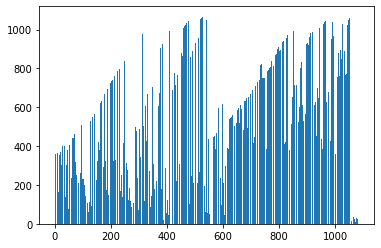

,feature
0,mut_residue
1,len
59,FASG760101
413,FUKS010101
440,SUYM030101
539,KOSJ950106
547,KOSJ950114
557,DOSZ010101
559,DOSZ010103
1055,AA20D.A


In [13]:
rfe = joblib.load('Feature_selected_1/lightgbm_feature_select_20.rfe')
print("LGBM-RFE特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfe.n_features_)
rank = list(rfe.ranking_)
columns = X_train.columns.tolist()
feature_selected = pd.DataFrame({'rank':rank,'feature':columns})
feature_selected

plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
plt.show()
feature_selected[feature_selected['rank']==1].iloc[:,1:]

# 50

In [10]:
rfe=RFE(estimator=model,n_features_to_select=50,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_1/lightgbm_feature_select_50.rfe")

[ True  True False ...  True  True  True]
[  1   1 245 ...   1   1   1]


['Feature_selected/lightgbm_feature_select_50.rfe']

LGBM-RFE特征选择结果——————————————————————————————————————————————————
有效特征个数 : 50


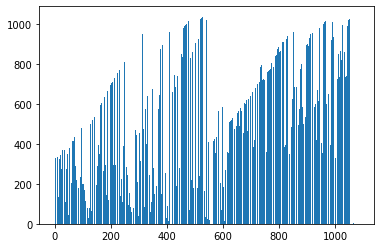

,feature
0,mut_residue
1,len
59,FASG760101
62,FASG760104
93,HUTJ700101
101,ISOY800106
125,KRIW790102
255,QIAN880126
257,QIAN880128
388,WIMW960101


In [14]:
rfe = joblib.load('Feature_selected/lightgbm_feature_select_50.rfe')
print("LGBM-RFE特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfe.n_features_)
rank = list(rfe.ranking_)
columns = X_train.columns.tolist()
feature_selected = pd.DataFrame({'rank':rank,'feature':columns})
feature_selected

plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
plt.show()
feature_selected[feature_selected['rank']==1].iloc[:,1:]

# 100

In [11]:
rfe=RFE(estimator=model,n_features_to_select=100,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_2/lightgbm_feature_select_100.rfe")

[ True  True False ...  True  True  True]
[  1   1 195 ...   1   1   1]


['lightgbm_feature_select_100.rfe']

# WithoutGO_Functional

# 1

In [ ]:
y_train = train.is_del.values
X_train = train.iloc[:,train.columns != "nutation"].iloc[:,4:].iloc[:,:-2]

model = lgb.LGBMClassifier()
rfe=RFE(estimator=model,n_features_to_select=1,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_2/lightgbm_feature_select_1_N.rfe")

In [ ]:
rfe = joblib.load('Feature_selected_2/lightgbm_feature_select_1_N.rfe')
print("LGBM-RFE特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfe.n_features_)
rank = list(rfe.ranking_)
columns = X_train.columns.tolist()
feature_selected = pd.DataFrame({'rank':rank,'feature':columns})
feature_selected

plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
plt.show()
feature_selected[feature_selected['rank']==1].iloc[:,1:]

# 10

In [10]:
y_train = train.is_del.values
X_train = train.iloc[:,train.columns != "nutation"].iloc[:,4:].iloc[:,:-2]

model = lgb.LGBMClassifier()
rfe=RFE(estimator=model,n_features_to_select=10,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_2/lightgbm_feature_select_10_N.rfe")

[ True  True False ...  True  True False]
[  1   1 374 ...   1   1  47]


['Feature_selected_2/lightgbm_feature_select_10_N.rfe']

In [13]:
X_train

,mut_residue,len,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,...,AA20D.W,AA20D.Y,NonPolarAA,PolarAA,ChargedAA,PosAA,NegAA,hits,score,pos_1
0,1,329,0.57,-0.14,1.59,1.82,0.18,0.00,0.27,-0.091,...,1,0,6,0,6,0,6,6,0.00,1
1,156,329,0.01,0.40,-0.18,-0.13,0.09,0.10,0.00,0.048,...,0,0,13,1,9,6,3,6,0.08,0
2,159,329,-0.10,-1.83,0.58,0.13,-0.09,-0.28,0.00,0.087,...,0,0,14,1,8,6,2,6,0.08,0
3,232,329,-0.27,-0.47,-1.69,-0.78,0.46,0.07,0.00,0.183,...,1,2,11,3,9,4,5,6,0.05,0
4,528,329,-0.32,-2.05,-0.57,-0.63,-0.21,-0.05,-0.13,0.224,...,1,0,12,1,10,7,3,39,0.01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45568,27,517,0.08,-0.47,0.61,0.28,-0.29,0.17,0.11,-0.004,...,0,0,10,7,6,4,2,30,0.71,0
45569,14,491,-0.02,1.25,0.59,0.52,0.47,0.33,-0.60,-0.158,...,0,0,10,8,5,3,2,399,0.02,0
45570,236,1257,0.46,-0.92,-2.92,-2.64,-0.40,0.00,0.22,-0.042,...,0,0,11,2,10,7,3,4,0.00,0
45571,239,1257,-0.08,0.47,-0.61,-0.28,0.29,-0.17,-0.11,0.004,...,0,0,10,2,11,6,5,4,0.00,0


# 20

In [11]:
rfe=RFE(estimator=model,n_features_to_select=20,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_2/lightgbm_feature_select_20_N.rfe")

[ True  True False ...  True  True False]
[  1   1 364 ...   1   1  37]


['Feature_selected_2/lightgbm_feature_select_20_N.rfe']

In [ ]:
rfe = joblib.load('Feature_selected_2/lightgbm_feature_select_20_N.rfe')
print("LGBM-RFE特征选择结果——————————————————————————————————————————————————")
print("有效特征个数 : %d" % rfe.n_features_)
rank = list(rfe.ranking_)
columns = X_train.columns.tolist()
feature_selected = pd.DataFrame({'rank':rank,'feature':columns})
feature_selected

plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
plt.show()
feature_selected[feature_selected['rank']==1].iloc[:,1:]

# 50

In [9]:
rfe=RFE(estimator=model,n_features_to_select=50,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_2/lightgbm_feature_select_50_N.rfe")

[ True  True False ...  True  True False]
[  1   1 334 ...   1   1   7]


['Feature_selected_2/lightgbm_feature_select_50_N.rfe']

# 100

In [10]:
rfe=RFE(estimator=model,n_features_to_select=100,step=1)
rfe=rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
joblib.dump(rfe, "Feature_selected_2/lightgbm_feature_select_100_N.rfe")

[ True  True False ...  True  True  True]
[  1   1 284 ...   1   1   1]


['Feature_selected_2/lightgbm_feature_select_100_N.rfe']